# Reference Trajectories

This notebook covers the generation of smooth, physically realizable reference trajectories for the tank drive robot. A key insight: **the reference trajectory must satisfy the robot dynamics**, otherwise no controller can track it.

## Control Decomposition

For trajectory tracking, control is decomposed into:

$$\mathbf{u} = \mathbf{u}_{ref} + \mathbf{u}_{fb}$$

- $\mathbf{u}_{ref}$: **Feedforward** — the control required to execute the reference trajectory
- $\mathbf{u}_{fb}$: **Feedback** — corrects deviations from the reference

The feedforward term is computed from the reference trajectory itself. Without it, the controller must constantly "catch up" to a moving target, resulting in persistent tracking error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import generate_smooth_reference_trajectory, angle_wrap

In [2]:
# Robot parameters
L = 0.14        # wheelbase [m]
tau = 0.2       # motor time constant [s]
v_cruise = 0.25 # cruise speed [m/s]
u_max = 0.5     # max wheel command [m/s]

# Simulation parameters
T_final = 60.0
dt = 0.05       # 20 Hz
t = np.arange(0, T_final, dt)

print(f"Robot: L={L*100:.0f}cm, τ={tau}s")
print(f"Simulation: {T_final}s at {1/dt:.0f}Hz ({len(t)} steps)")

Robot: L=14cm, τ=0.2s
Simulation: 60.0s at 20Hz (1200 steps)


## Physically Realizable Trajectories

A trajectory is realizable if it satisfies:

1. **Kinematic constraints**: Heading must be consistent with velocity direction (for forward motion)
2. **Dynamic constraints**: Wheel velocities cannot change instantaneously (motor dynamics)
3. **Actuator limits**: Wheel commands must stay within $[-u_{max}, u_{max}]$

### The Turn Problem

Consider a waypoint trajectory that changes heading by 90°. If we simply interpolate positions, the heading must change **instantaneously** at the waypoint — requiring infinite angular velocity.

Solution: Include explicit **turn phases** where the robot adjusts heading while stationary or moving slowly.

In [3]:
# Define waypoints for a multi-segment trajectory
waypoints = np.array([
    [0.0, 0.0],
    [3.0, 3.0],   # 45° heading
    [6.0, 2.0],   # -18° heading (turn right)
    [8.0, 5.0],   # 56° heading (turn left)
])

# Show segment headings
print("Waypoint sequence:")
for i in range(len(waypoints) - 1):
    p1, p2 = waypoints[i], waypoints[i+1]
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    heading = np.degrees(np.arctan2(dy, dx))
    dist = np.sqrt(dx**2 + dy**2)
    print(f"  Segment {i+1}: ({p1[0]:.1f}, {p1[1]:.1f}) → ({p2[0]:.1f}, {p2[1]:.1f})  |  {heading:+.1f}°  |  {dist:.2f}m")

Waypoint sequence:
  Segment 1: (0.0, 0.0) → (3.0, 3.0)  |  +45.0°  |  4.24m
  Segment 2: (3.0, 3.0) → (6.0, 2.0)  |  -18.4°  |  3.16m
  Segment 3: (6.0, 2.0) → (8.0, 5.0)  |  +56.3°  |  3.61m


## Trajectory Generation

The `generate_smooth_reference_trajectory` function creates trajectories with:

1. **Turn phases**: Robot rotates in place to align with the next segment
2. **Straight phases**: Constant-velocity motion along each segment
3. **Feedforward**: Control inputs computed from the reference velocities

### Turn-in-Place Kinematics

For pure rotation (no translation), we need equal and opposite wheel velocities:

$$\dot{\theta} = \frac{v_r - v_l}{L} = \omega$$

$$v_l + v_r = 0 \quad \text{(no forward motion)}$$

Solving: $v_r = \omega L / 2$, $v_l = -\omega L / 2$

In [4]:
# Generate smooth trajectory with turn phases
turn_time = 1.0  # seconds allocated for each turn
x_ref, u_ref = generate_smooth_reference_trajectory(waypoints, t, v_cruise, L, tau, turn_time)

print(f"Generated trajectory:")
print(f"  x_ref shape: {x_ref.shape} (5 states × {x_ref.shape[1]} timesteps)")
print(f"  u_ref shape: {u_ref.shape} (2 inputs × {u_ref.shape[1]} timesteps)")

Generated trajectory:
  x_ref shape: (5, 1200) (5 states × 1200 timesteps)
  u_ref shape: (2, 1200) (2 inputs × 1200 timesteps)


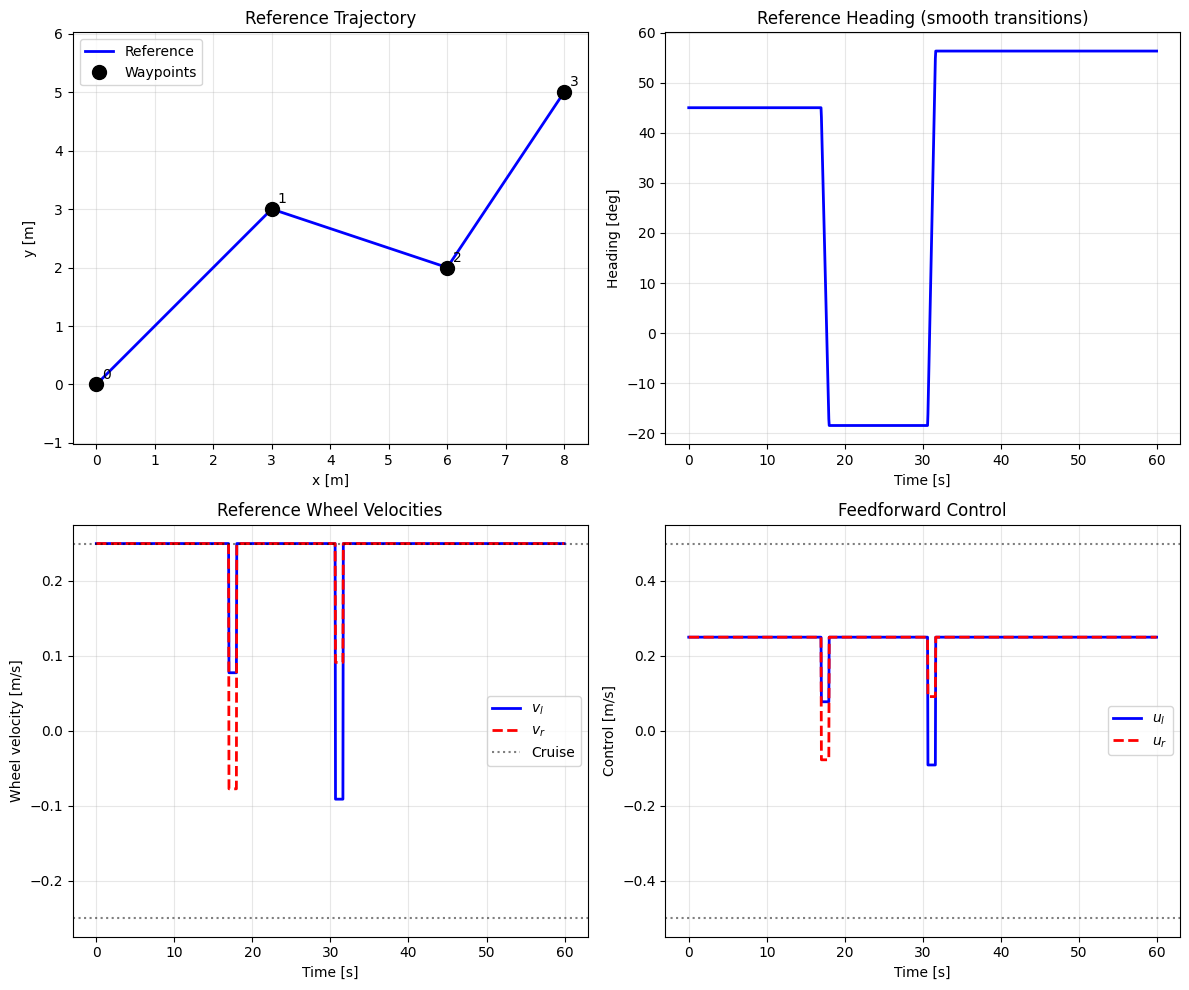

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Trajectory in x-y plane
ax = axes[0, 0]
ax.plot(x_ref[0, :], x_ref[1, :], 'b-', linewidth=2, label='Reference')
ax.plot(waypoints[:, 0], waypoints[:, 1], 'ko', markersize=10, label='Waypoints')
for i, wp in enumerate(waypoints):
    ax.annotate(f'{i}', (wp[0]+0.1, wp[1]+0.1), fontsize=10)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Reference Trajectory')

# Heading over time
ax = axes[0, 1]
ax.plot(t, np.degrees(x_ref[2, :]), 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Heading [deg]')
ax.grid(True, alpha=0.3)
ax.set_title('Reference Heading (smooth transitions)')

# Wheel velocities
ax = axes[1, 0]
ax.plot(t, x_ref[3, :], 'b-', linewidth=2, label='$v_l$')
ax.plot(t, x_ref[4, :], 'r--', linewidth=2, label='$v_r$')
ax.axhline(v_cruise, color='k', linestyle=':', alpha=0.5, label='Cruise')
ax.axhline(-v_cruise, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Wheel velocity [m/s]')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Reference Wheel Velocities')

# Feedforward control
ax = axes[1, 1]
ax.plot(t, u_ref[0, :], 'b-', linewidth=2, label='$u_l$')
ax.plot(t, u_ref[1, :], 'r--', linewidth=2, label='$u_r$')
ax.axhline(u_max, color='k', linestyle=':', alpha=0.5)
ax.axhline(-u_max, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Control [m/s]')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Feedforward Control')

plt.tight_layout()
plt.show()

## Feedforward Computation

The feedforward control $\mathbf{u}_{ref}$ is the input required to achieve the reference wheel velocities, accounting for motor dynamics.

### Steady-State Feedforward

From the motor dynamics $\dot{v}_l = (u_l - v_l)/\tau$, at steady state ($\dot{v}_l = 0$):

$$u_l = v_l$$

For constant-velocity motion, the feedforward equals the desired velocity.

### Dynamic Feedforward

During velocity changes, the feedforward must account for acceleration:

$$u_l = v_l + \tau \dot{v}_l$$

For the turn-in-place phases, this is implicitly handled by setting $u_{ref}$ equal to the desired turn velocities (which ramp up/down over the turn duration).

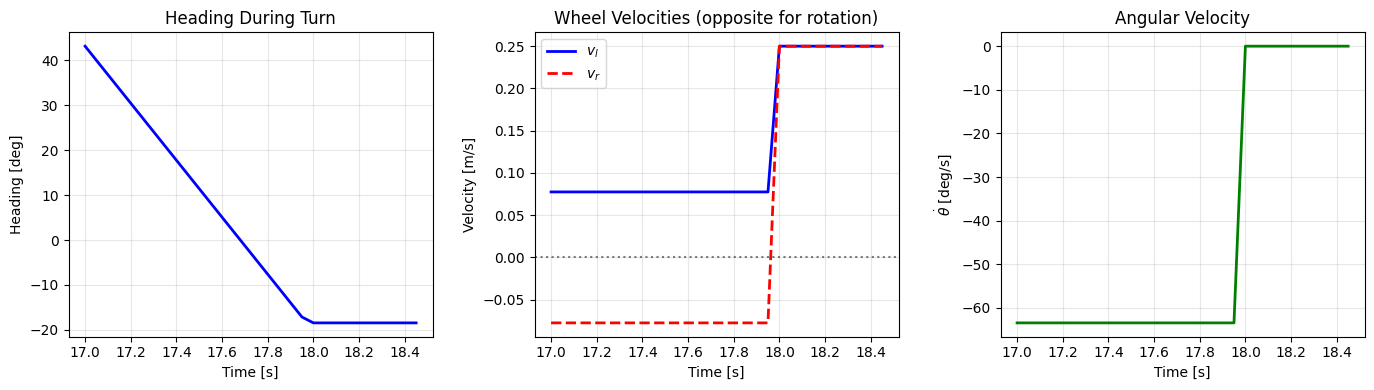

In [6]:
# Zoom in on a turn phase
# Find a turn by looking for sign change in (v_r - v_l)
omega_ref = (x_ref[4, :] - x_ref[3, :]) / L  # angular velocity

# Find first significant turn
turn_start = np.argmax(np.abs(omega_ref) > 0.1)
turn_end = turn_start + int(turn_time / dt) + int(0.5 / dt)

t_zoom = t[turn_start:turn_end]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.plot(t_zoom, np.degrees(x_ref[2, turn_start:turn_end]), 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Heading [deg]')
ax.grid(True, alpha=0.3)
ax.set_title('Heading During Turn')

ax = axes[1]
ax.plot(t_zoom, x_ref[3, turn_start:turn_end], 'b-', linewidth=2, label='$v_l$')
ax.plot(t_zoom, x_ref[4, turn_start:turn_end], 'r--', linewidth=2, label='$v_r$')
ax.axhline(0, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Velocity [m/s]')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Wheel Velocities (opposite for rotation)')

ax = axes[2]
ax.plot(t_zoom, np.degrees(omega_ref[turn_start:turn_end]), 'g-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\\dot{\\theta}$ [deg/s]')
ax.grid(True, alpha=0.3)
ax.set_title('Angular Velocity')

plt.tight_layout()
plt.show()

## Summary

Key points for reference trajectory generation:

1. **Include turn phases** — instantaneous heading changes are impossible
2. **Compute feedforward** — the control required to execute the trajectory
3. **Respect actuator limits** — ensure $|u_{ref}| \leq u_{max}$
4. **Smooth velocity profiles** — avoid step changes that motors cannot track

The trajectory generator produces:
- `x_ref`: Reference states $[x, y, \theta, v_l, v_r]$ at each timestep
- `u_ref`: Feedforward controls $[u_l, u_r]$ at each timestep

These are used by the controllers in the [Controllers](Controllers.ipynb) notebook, where the full tracking control law $\mathbf{u} = \mathbf{u}_{ref} + \mathbf{u}_{fb}$ is implemented.